In [1]:
from helpers.utilities import *
%run helpers/notebook_setup.ipynb

In [2]:
indexed_by_target_path = 'data/clean/protein/indexed_by_target.csv'
patients_variance_at_one_path ='data/clean/protein/z_log_10-patients_variance_at_one.csv'
zz_log_path = 'data/clean/protein/zz_log_10.csv'
log_matrix_path = 'data/clean/protein/log_10.csv'

clinical_path = 'data/clean/protein/clinical_data_ordered_to_match_proteins_matrix.txt'

In [3]:
raw_protein_matrix = read_csv(indexed_by_target_path, index_col=0)
log_matrix = read_csv(log_matrix_path, index_col=0)
zz_log_matrix = read_csv(zz_log_path, index_col=0)
patients_variance_at_one = read_csv(patients_variance_at_one_path, index_col=0)

In [4]:
clinical = read_csv(clinical_path, index_col=0)

In [5]:
by_condition = clinical['Meningitis']
conditions =  sorted(set(by_condition))

In [6]:
matrices = {
    'raw': raw_protein_matrix,
    'log': log_matrix,
    'z-score patients then z-score proteins': zz_log_matrix,
    'z-score patients': patients_variance_at_one
}

## Patient-to-patient variance of each of the proteins, grouped by their condition:

In [7]:
proteins_variance = []
for condition in conditions:
    for transform, matrix in matrices.items():
        for protein, variance in matrix.T[by_condition == condition].T.var(axis=1).items():
            proteins_variance.append(
                {
                    'condition': condition,
                    'transform': transform,
                    'variance': variance,
                    'protein': protein,
                    'variance_ratio': variance / matrix.loc[protein].var()
                }
            )
proteins_variance = DataFrame(proteins_variance)
proteins_variance.head()

,condition,protein,transform,variance,variance_ratio
0,Cryptococcal,CHIP,raw,5.916837e+03,0.036270
1,Cryptococcal,CEBPB,raw,1.021597e+03,0.097015
2,Cryptococcal,NSE,raw,2.006106e+07,0.458795
3,Cryptococcal,PIAS4,raw,6.622159e+02,0.128626
4,Cryptococcal,IL-10 Ra,raw,4.266223e+03,0.313316


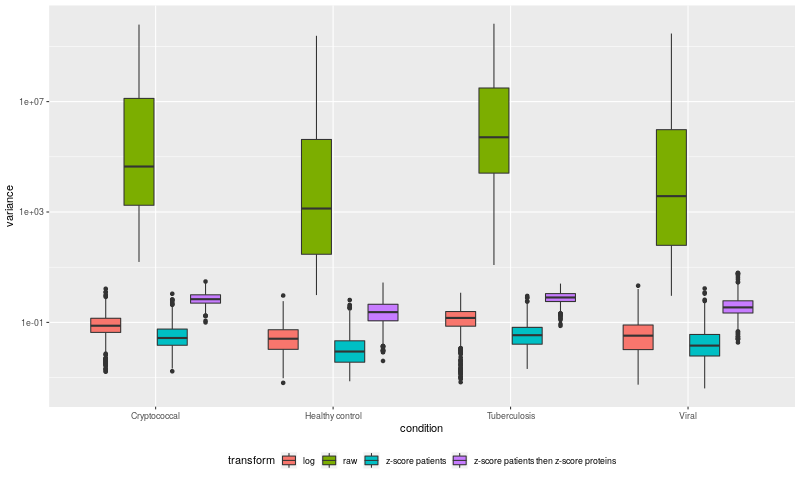

In [8]:
%%R -i proteins_variance -w 800
(
    ggplot(proteins_variance, aes(x=condition, y=variance, fill=transform))
    + geom_boxplot()
    + scale_y_log10()
    + theme(legend.position='bottom')
)

If we assume that the variance of proteins between patients in the same group should be lower than the variance between proteins among all samples, we can get a meaningful comparison of the proposed transformations:

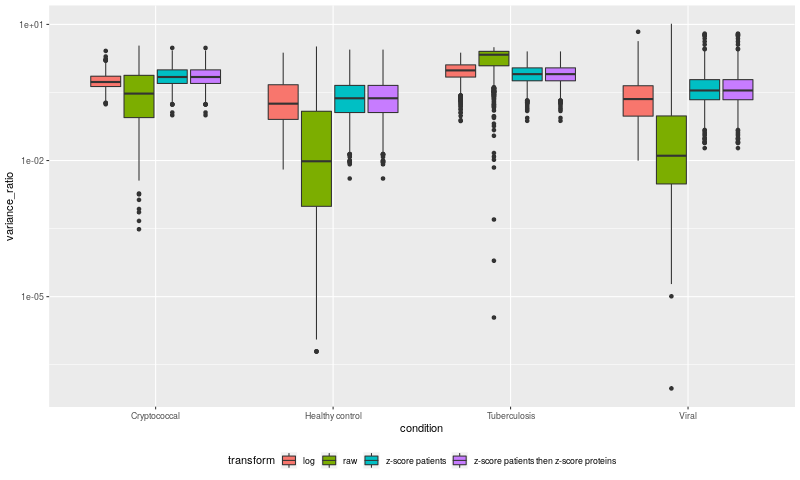

In [9]:
%%R -i proteins_variance -w 800
(
    ggplot(proteins_variance, aes(x=condition, y=variance_ratio, fill=transform))
    + geom_boxplot()
    + scale_y_log10()
    + theme(legend.position='bottom')
)

- It is not obvious if the comparison of raw values to log transformed values gives us a clear picture (because the division by log transformed value and by raw value is not the same thing), but
- it seems that the benefit of log transform is the greatest in the TB group (worth remembering)
- the same goes for fixing the variance of each patient at one (benefit visible in the TB group)
- and for the double z-score transform. While in the absolute terms the in-group variance for this procedure increased (see the plot above), when we compared it to the global variance, this method is as good as single z-score - which is contrary to my  consternations

## Protein-to-protein variance of each of the patients, grouped by their condition:

This time I compare how variable is each sample (patient) against the group that they belong to. This one has no strong biological intuition, but one could say that very similar patients should have comparable variances. This is of course an oversimplification and generally not true in many situations.

In [10]:
patients_variance = []
for condition in conditions:
    for transform, matrix in matrices.items():
        for patient, variance in matrix.T[by_condition == condition].T.var(axis=0).items():
            patients_variance.append(
                {
                    'condition': condition,
                    'transform': transform,
                    'variance': variance,
                    'patient': patient,
                    'variance_ratio': variance / matrix.T[by_condition == condition].T.var().mean(),
                }
            )
patients_variance = DataFrame(patients_variance)
patients_variance.head()

,condition,patient,transform,variance,variance_ratio
0,Cryptococcal,016.CM,raw,1.236473e+09,0.920972
1,Cryptococcal,006.CM,raw,1.416878e+09,1.055345
2,Cryptococcal,015.CM,raw,1.958862e+09,1.459035
3,Cryptococcal,013.CM,raw,9.029527e+08,0.672554
4,Cryptococcal,018.CM,raw,1.201501e+09,0.894923


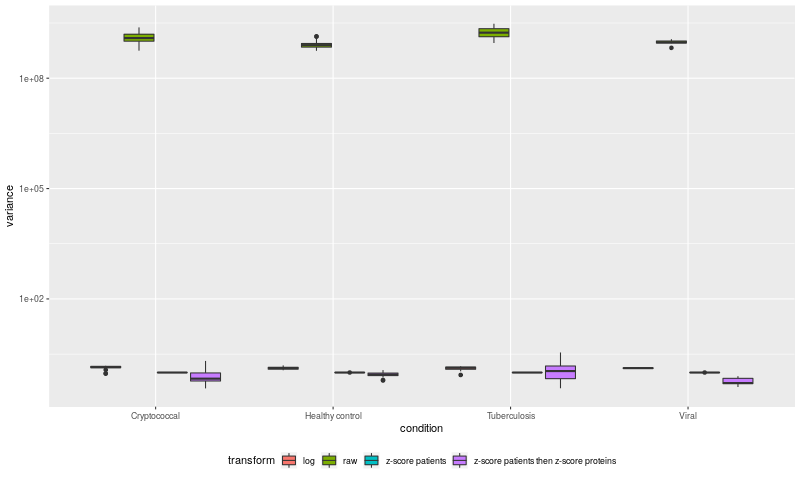

In [11]:
%%R -i patients_variance -w 800
(
    ggplot(patients_variance, aes(x=condition, y=variance, fill=transform))
    + geom_boxplot()
    + scale_y_log10()
    + theme(legend.position='bottom')
)

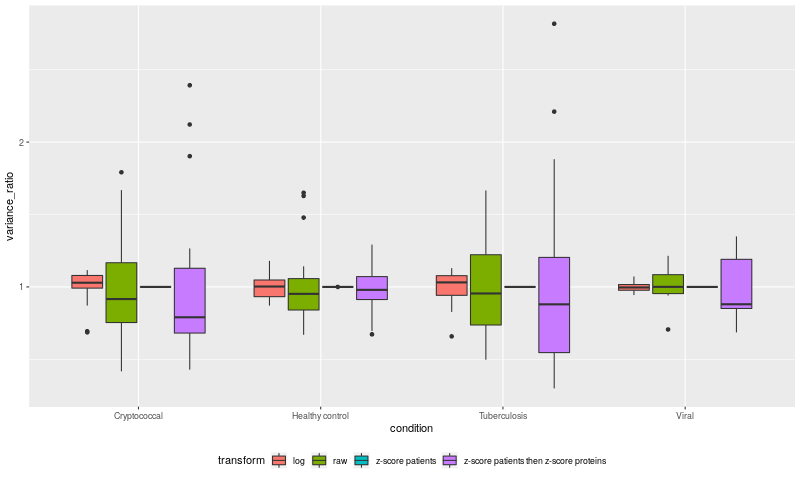

In [12]:
%%R -i patients_variance -w 800
(
    ggplot(patients_variance, aes(x=condition, y=variance_ratio, fill=transform))
    + geom_boxplot()
    + theme(legend.position='bottom')
)
# closer to one = variances more similar = the desired output

- the single z-score transform has unit variance on patients by definition thus is not worth additional discussion
- the double z-score performs (on average) considerably worse than other methods (as expected - this is the cost of the trade-off of having fixed variance in proteins rather than patients)

### Mean abundance of proteins in each of the patients, compared against the mean of the group

In non-transformed data this is influenced by:
 - the disease
 - the technical variation
 
If we compare the patients proteins abundance to the mean abundance of the disease group, we expect to get comparable results.

A good transformation would reduce the technical variation thus reducing the variance in such comparison.

In [13]:
patients_mean_protein_abundance = []
for condition in conditions:
    for transform, matrix in matrices.items():
        mean_condition = matrix.T[by_condition == condition].T.mean(axis=0).mean()
        # print(condition, transform, mean_condition)
        for patient, mean in matrix.T[by_condition == condition].T.mean(axis=0).items():
            patients_mean_protein_abundance.append(
                {
                    'condition': condition,
                    'transform': transform,
                    'mean': mean,
                    'patient': patient,
                    'mean_ratio': mean / mean_condition,
                }
            )
patients_mean_protein_abundance = DataFrame(patients_mean_protein_abundance)
patients_mean_protein_abundance.head()

,condition,mean,mean_ratio,patient,transform
0,Cryptococcal,13606.752337,1.081039,016.CM,raw
1,Cryptococcal,15630.479923,1.241822,006.CM,raw
2,Cryptococcal,16001.292874,1.271283,015.CM,raw
3,Cryptococcal,10326.165977,0.820401,013.CM,raw
4,Cryptococcal,13048.722146,1.036705,018.CM,raw


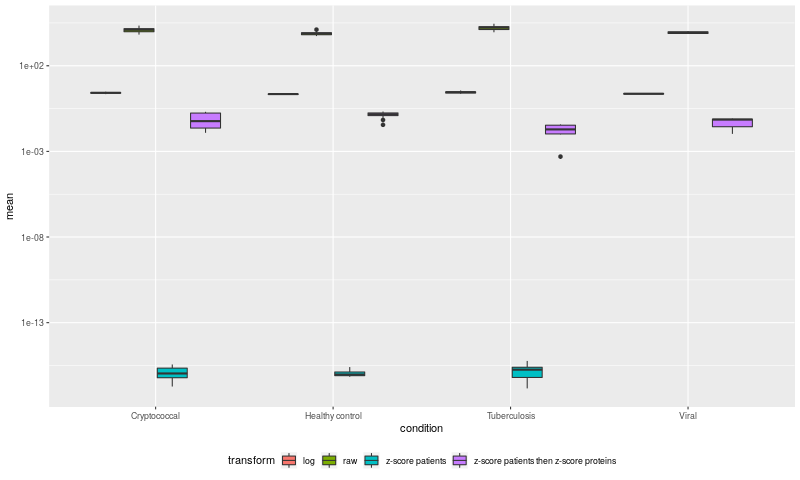

In [14]:
%%R -i patients_mean_protein_abundance -w 800
(
    ggplot(patients_mean_protein_abundance, aes(x=condition, y=mean, fill=transform))
    + geom_boxplot()
    + scale_y_log10()
    + theme(legend.position='bottom')
)

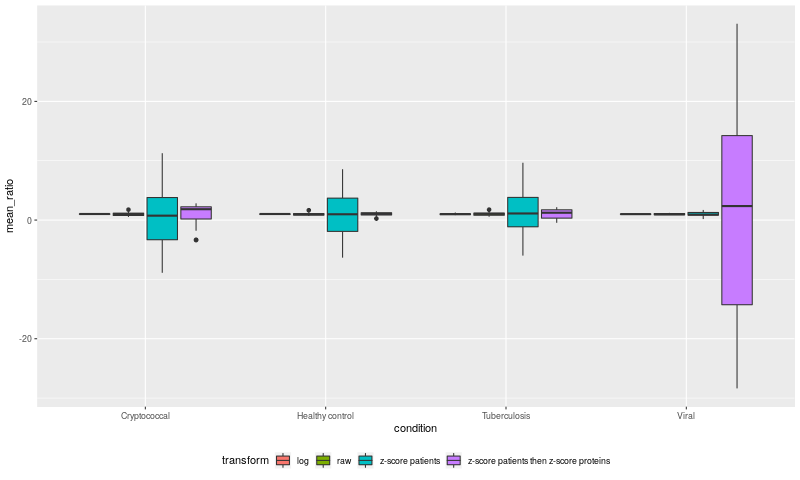

In [15]:
%%R -i patients_mean_protein_abundance -w 800
(
    ggplot(patients_mean_protein_abundance, aes(x=condition, y=mean_ratio, fill=transform))
    + geom_boxplot()
    + theme(legend.position='bottom')
)

- single z-score (patients variance = 1, mean = 0) performed worse. It should not. This may be due to instability of the computations (we are dividing a number which is essentially a 0 by another number which is a mean of multiple "almost" zeros, e.g. -3.598654e-16 / 6.011499383558319e-17 (see below)
- the results for viral/double z-score are concerning. This seems to the most important finding in this notebook.

In [16]:
patients_mean_protein_abundance[patients_mean_protein_abundance['transform']=='z-score patients'].head()

,condition,mean,mean_ratio,patient,transform
72,Cryptococcal,1.083850e-16,3.361478,016.CM,z-score patients
73,Cryptococcal,1.643641e-16,5.097625,006.CM,z-score patients
74,Cryptococcal,1.871640e-17,0.580475,015.CM,z-score patients
75,Cryptococcal,1.905670e-17,0.591029,013.CM,z-score patients
76,Cryptococcal,2.234058e-16,6.928760,018.CM,z-score patients


### Why double z-score transform increases the difference between means in the viral group?

The data must not conform to our expectations. There is nothing unstable numerically:

In [17]:
double = patients_mean_protein_abundance[patients_mean_protein_abundance['transform']=='z-score patients then z-score proteins']
double.head()

,condition,mean,mean_ratio,patient,transform
48,Cryptococcal,-0.079070,1.303121,016.CM,z-score patients then z-score proteins
49,Cryptococcal,-0.171163,2.820864,006.CM,z-score patients then z-score proteins
50,Cryptococcal,-0.121595,2.003958,015.CM,z-score patients then z-score proteins
51,Cryptococcal,-0.113053,1.863173,013.CM,z-score patients then z-score proteins
52,Cryptococcal,-0.160406,2.643580,018.CM,z-score patients then z-score proteins


In [18]:
double[double.condition == 'Viral'].head()

,condition,mean,mean_ratio,patient,transform
314,Viral,-0.020827,7.215776,089.VM,z-score patients then z-score proteins
315,Viral,0.081895,-28.373649,095.VM,z-score patients then z-score proteins
316,Viral,-0.095498,33.086833,154.VM,z-score patients then z-score proteins
317,Viral,0.010576,-3.664303,156.VM,z-score patients then z-score proteins
318,Viral,0.071804,-24.877565,165.VM,z-score patients then z-score proteins


How is the Viral group different?

- fewer samples
- potentially different diseases?

Hypothesis 1: there are to few samples

TODO: test by simulation (permutations test)